<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Business_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import os
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

from scipy.spatial import KDTree
from scipy.spatial import distance_matrix
from scipy.special import softmax, expit

import torch

np.random.seed(0)

# loading dataset to a system path
if not os.path.exists("/content/bank.zip"):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

zip_file = ZipFile('/content/bank.zip')

### testing codes


In [18]:
def load_dataset(impute=True):
    # two datasets: bank.csv is random 10% of bank-full.csv
    dataset = pd.read_csv(zip_file.open('bank.csv'), sep=';')
    print(f'Original Dataset Loaded:\n{dataset}')
    n,d = dataset.shape
    
    X = []

    job_dict = {'unknown'       : None,
                'admin.'        : 0,
                'unemployed'    : 1,
                'management'    : 2,
                'housemaid'     : 3,
                'entrepreneur'  : 4,
                'student'       : 5,
                'blue-collar'   : 6,
                'self-employed' : 7,
                'retired'       : 8,
                'technician'    : 9,
                'services'      : 10}
    
    marital_dict = {'married' : 0,
                    'divorced': 1,
                    'single'  : 2}
    
    education_dict = {'unknown'   : None,
                      'primary'   : 0,
                      'secondary' : 1,
                      'tertiary'  : 2}
    
    yesno_dict = {'no'  : 0,
                  'yes' : 1}
    
    contact_dict = {'unknown'   : None,
                    'telephone' : 0,
                    'cellular'  : 1}
    
    month_dict = {'jan' : 1,
                  'feb' : 2,
                  'mar' : 3,
                  'apr' : 4,
                  'may' : 5,
                  'jun' : 6,
                  'jul' : 7,
                  'aug' : 8,
                  'sep' : 9,
                  'oct' : 10,
                  'nov' : 11,
                  'dec' : 12}

    print(f"Percentage unknown for job: {dataset.job.to_list().count('unknown')/n*100}")
    print(f"Percentage unknown for marital: {dataset.marital.to_list().count('unknown')/n*100}")
    print(f"Percentage unknown for education: {dataset.education.to_list().count('unknown')/n*100}")
    print(f"Percentage unknown for contact (contact communication type): {dataset.contact.to_list().count('unknown')/n*100}")
    print(f"Percentage unknown for poutcome (outcome from previous marketing campaign): {dataset.poutcome.to_list().count('unknown')/n*100}")
    print(f"Percentage -1 for pdays (clients not previously contacted from a previous campaign): {dataset.pdays.to_list().count(-1)/n*100}")

    # poutcome and pdays are neglected since percentage unknown is too large
    # precious is neglected as well since it's connected with previous campaign information
    # contact is neglected since percentage is large (28%) and seems irrevalant

    for name, data in dataset.items():
        if name == "y":
            y = np.array([int(yesno_dict[x]) for x in data])
        elif name in ("default", "housing", "loan"):
            X.append([yesno_dict[x] for x in data])
        elif name == "job":
            X.append([job_dict[x] for x in data])
        elif name == "marital":
            X.append([marital_dict[x] for x in data])
        elif name == "education":
            X.append([education_dict[x] for x in data])
        elif name == "month":
            X.append([month_dict[x] for x in data])
        else:
            if name not in ("poutcome", "pdays", "contact", "previous"):
              X.append([int(x) for x in data])

    X = np.array(X).T

    # Use KNN to fill in unknown data
    if impute == True:
        imputer = KNNImputer(n_neighbors=2)
        X = imputer.fit_transform(X)
    
    return X, y


def plot_parameters(theta_gt, theta_est):
    fig, ax = plt.subplots(1)
    ax.scatter(theta_gt[:, 0], theta_gt[:, 1], label="True Parameters")
    ax.scatter(theta_est[:, 0], theta_est[:, 1], label="EST. Parameters")
    ax.legend()
    return fig, ax


def print_metrics(dic):
    message = f"\n"
    for k, v in dic.items():
        message += f"{k}:\t{v}\n"
    print(message)


def evaluate_method(method, X_test, y_test, method_name, U_test=None):
    if method_name == "Linear Regression" or method_name == "Gaussian Mixture":
        pred = method.predict(X_test)
        y_pred = (pred>0.5)*1
        # y_prob = expit(pred).reshape((-1, 1))
        y_prob = np.clip(pred, 0, 1).reshape((-1, 1))
        y_prob = np.concatenate((1-y_prob, y_prob), axis=1)
    elif method_name == "Personalized Regression":
        y_pred = method.predict(X_test, U_test)
        y_prob = method.predict_proba(X_test, U_test)
    else:
        y_pred = method.predict(X_test)
        y_prob = method.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob[:, 1])
    performance_dict = {"method_name": method_name,
                        "accuracy": accuracy,
                        "precision": precision,
                        "recall": recall,
                        "fscore": fscore,
                        "auroc": auroc}
    return performance_dict

In [19]:
class PRBinaryClassifier():
    def __init__(self, args, theta_pop, trainset, validset=None):
        # Training Parameters
        self.cov_norm_ord = args.covariate_norm_ord
        self.cov_xstart = args.covariate_x_start
        self.cov_xend= args.covariate_x_end
        self.sigma_theta = args.sigma_theta
        self.lambd = args.theta_regularizer
        self.gamma = args.distance_regularizer
        self.nu = args.phi_regularizer
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim
        self.k = args.covariate_dim
        self.log_steps = args.log_steps
        self.n_neighbors = args.n_neighbors
        self.show_logs = args.show_logs
        self.use_distance_loss = args.use_distance_loss

        self.theta_pop = torch.from_numpy(theta_pop)
        self.p = self.theta_pop.shape[0]

        # Training Data
        X_train, y_train, U_train = trainset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train).to(dtype=torch.double)
        self.__init_U_train(U_train)
        self.n = self.X_train.shape[0]

        # Validation Data
        if type(validset) != "NoneType":
            self.eval = True
            self.X_eval, self.y_eval, self.U_eval = validset
        else: 
            self.eval = False

        # Variable Initialization
        PI = np.random.multivariate_normal(theta_pop, self.sigma_theta*np.eye(self.p), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        # why divide by k?
        self.phi = torch.ones((self.k, ), dtype=torch.float64) / self.k

        # Loss Functions
        self.__sample_specific_loss = torch.nn.BCELoss(reduction="sum")
        self.__parameter_regularizer = torch.nn.L1Loss()
        self.__phi_regularizer = torch.nn.MSELoss()
        self.__distance_loss = torch.nn.MSELoss()


    def train(self, n_epoch=5):
        for epoch in range(n_epoch):
            # Require Gradient for variables
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)
            PI = self.__update_PI(Z, Q) 

            y_prob = self.__predict_proba(self.X_train, PI)

            # Calculate Loss
            l_loss = self.__sample_specific_loss(y_prob, self.y_train)
            D_loss = self.__distance_matching_regularizer(Z, phi) if self.use_distance_loss else 0
            theta_loss = self.__parameter_regularizer(PI, torch.zeros_like(PI))
            phi_sum = torch.sum(phi, dim=0, keepdim=True)
            phi_loss = self.__phi_regularizer(phi_sum, torch.ones_like(phi_sum)) # Weight should sum to one
            loss = l_loss + self.gamma * D_loss + self.lambd * theta_loss + self.nu * phi_loss
            
            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)

            # self.Z -= alpha_cust * Z.grad
            self.Z -= torch.bmm(Z.grad.unsqueeze(2), alpha_cust.unsqueeze(2)).squeeze()

            # Update Q
            self.Q -= self.alpha * Q.grad

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = self.__update_PI(self.Z, self.Q)

            if self.show_logs and epoch % self.log_steps == 0:
                message = f"Epoch {epoch+1} - Total loss: {loss}\tDistance loss:{D_loss}"
                print("-"*20)
                print(message)
                if self.eval:
                    print_metrics(evaluate_method(self, self.X_eval, self.y_eval, "Personalized Regression", self.U_eval))
                print("-"*20)
        

    def predict(self, X_test, U_test):
        y_prob = self.predict_proba(X_test, U_test)
        y_pred = y_prob.argmax(axis=1)
        return y_pred


    def predict_proba(self, X_test, U_test):
        X = torch.from_numpy(X_test)
        dist_mat_test = self.__create_distance_matrix(self.U_train.numpy(), U_test)
        _, idx_sets = torch.matmul(dist_mat_test, self.phi).topk(self.n_neighbors, dim=1, largest=False)
        PI = self.PI[idx_sets, :].mean(axis=1)
        prob = self.__predict_proba(X, PI).detach().numpy().reshape((-1, 1))
        y_prob = np.concatenate((1-prob, prob), axis=1)
        return y_prob


    def __predict_proba(self, X, PI):
        prob = torch.bmm(X.unsqueeze(1), PI.unsqueeze(2)).squeeze()
        prob = torch.sigmoid(prob)
        return prob

    def __create_distance_matrix(self, A, B):
        dist_mat = []
        for i in range(self.k):
            dist_mat.append(distance_matrix(A[:, [i]], B[:, [i]], p=self.cov_norm_ord))
        dist_mat = torch.from_numpy(np.array(dist_mat)).T
        return dist_mat

    def __init_U_train(self, U_train: np.array):
        self.U_train = torch.from_numpy(U_train)
        self.U_distance_mat = self.__create_distance_matrix(U_train, U_train)
        # print(f"Distance Matrix Shape: {self.U_distance_mat.shape}")


    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __update_PI(self, Z, Q):
      # why add theta_pop?
        return torch.mm(Z, Q) + self.theta_pop
    

    def __distance_matching_regularizer(self, Z, phi):       
        _Z = Z.detach().numpy()
        tree = KDTree(_Z)
        _, idx_set = tree.query(_Z, k=6)
        idx_set = idx_set[:, 1:]
        Z_set = Z[idx_set, :]
        delta_Z = Z.view(Z.shape[0], 1, -1).expand(-1, Z_set.shape[1], -1) - Z_set
        delta_Z = torch.linalg.norm(delta_Z, ord=2, dim=2)

        U_dist_idx = torch.from_numpy(idx_set).to(dtype=torch.int64).view(idx_set.shape[0], -1, 1).expand(-1, -1, self.k)
        U_dist_set = torch.gather(self.U_distance_mat, 1, U_dist_idx)
        rho_U = torch.matmul(U_dist_set, phi)
        d_loss = self.__distance_loss(delta_Z, rho_U)
        return d_loss


Original Dataset Loaded:
      age            job  marital  education  ... pdays  previous poutcome   y
0      30     unemployed  married    primary  ...    -1         0  unknown  no
1      33       services  married  secondary  ...   339         4  failure  no
2      35     management   single   tertiary  ...   330         1  failure  no
3      30     management  married   tertiary  ...    -1         0  unknown  no
4      59    blue-collar  married  secondary  ...    -1         0  unknown  no
...   ...            ...      ...        ...  ...   ...       ...      ...  ..
4516   33       services  married  secondary  ...    -1         0  unknown  no
4517   57  self-employed  married   tertiary  ...    -1         0  unknown  no
4518   57     technician  married  secondary  ...    -1         0  unknown  no
4519   28    blue-collar  married  secondary  ...   211         3    other  no
4520   44   entrepreneur   single   tertiary  ...   249         7    other  no

[4521 rows x 17 columns]
P

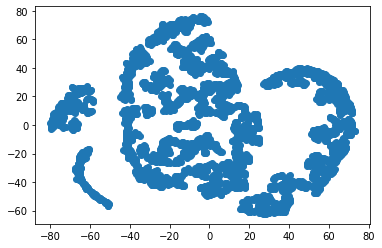

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


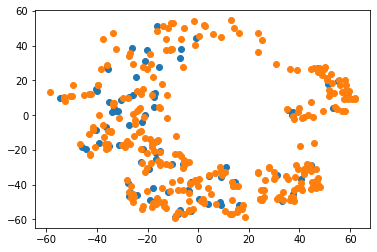


method_name:	Linear Regression
accuracy:	0.896112600536193
precision:	[0.90852391 0.53061224]
recall:	[0.98275862 0.16455696]
fscore:	[0.94418437 0.25120773]
auroc:	0.8497381056307289


method_name:	Gaussian Mixture
accuracy:	0.7365951742627346
precision:	[0.88220959 0.04980843]
recall:	[0.81409295 0.08227848]
fscore:	[0.84678363 0.06205251]
auroc:	0.4481857172679483


method_name:	Deep Neural Networks
accuracy:	0.896112600536193
precision:	[0.9177888  0.51851852]
recall:	[0.97076462 0.26582278]
fscore:	[0.9435337  0.35146444]
auroc:	0.8514603457764788


method_name:	Logistic Regression
accuracy:	0.896112600536193
precision:	[0.9154334  0.52054795]
recall:	[0.97376312 0.24050633]
fscore:	[0.94369778 0.32900433]
auroc:	0.8515457461142847


method_name:	Personalized Regression
accuracy:	0.8753351206434317
precision:	[0.91294964 0.3627451 ]
recall:	[0.95127436 0.23417722]
fscore:	[0.93171806 0.28461538]
auroc:	0.6764560757595885



In [20]:
class PR_Arguments():
    # Data Arguments
    sigma_theta = 0.001 #0.001
    theta_regularizer = 0.01
    distance_regularizer = 0.01
    phi_regularizer = 0

    # 
    n_neighbors = 5 #3
    latent_dim = 2
    covariate_dim = 2
    covariate_norm_ord = 2
    covariate_x_start = 2
    covariate_x_end = -1

    # Traing Arguments
    learning_rate = 4e-3 #4e-3
    lr_decay = 1-1e-4 #1-1e-4
    # Should be bigger or until converge
    n_epoch = 2000 #2000
    log_steps = 100
    show_logs = False
    use_distance_loss = False


def main():
    X, y = load_dataset()
    # U and X should be separated
    U = TSNE().fit_transform(X[:, 2:])
    plt.scatter(U[:, 0], U[:, 1])
    plt.show()
    X_train, X_test, y_train, y_test, U_train, U_test = train_test_split(X, y, U, test_size=0.33, random_state=42)
    idx_m = (X_train[:, 1] == 1)
    idx_f = (X_train[:, 1] == 0)
    
    ## Preprocessing
    scaler =  StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    ### Methods
    dict_list = []

    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    dict_lr = evaluate_method(lr, X_test, y_test, "Linear Regression")
    dict_list.append(dict_lr)

    ## Gaussian Mixture
    gmm = GaussianMixture(n_components=3).fit(X_train, y_train)
    dict_gmm = evaluate_method(gmm, X_test, y_test, "Gaussian Mixture")
    dict_list.append(dict_gmm)

    ## DNN
    dnn = MLPClassifier(hidden_layer_sizes=(50,)).fit(X_train, y_train.squeeze())
    dict_dnn = evaluate_method(dnn, X_test, y_test, "Deep Neural Networks")
    dict_list.append(dict_dnn)

    ## Logistic Regression
    lor = LogisticRegression().fit(X_train, y_train)
    dict_lor = evaluate_method(lor, X_test, y_test, "Logistic Regression")
    dict_list.append(dict_lor)

    ## Personalized Regression
    pr_args = PR_Arguments()
    theta_lor = np.concatenate((np.array(lor.coef_).T, np.array(lor.intercept_).reshape((-1, 1))), axis=0)
    # theta_lor = np.zeros_like(theta_lor)
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    trainset = (X_train, y_train, U_train)
    evalset = (X_test, y_test, U_test)
    pr = PRBinaryClassifier(pr_args, theta_lor.squeeze(), trainset, evalset)
    pr.train(pr_args.n_epoch)
    dict_pr = evaluate_method(pr, X_test, y_test, "Personalized Regression", U_test)
    dict_list.append(dict_pr)

    theta_pr = TSNE().fit_transform(pr.PI) 
    plt.scatter(theta_pr[idx_m, 0], theta_pr[idx_m, 1])
    plt.scatter(theta_pr[idx_f, 0], theta_pr[idx_f, 1])
    plt.show()

    for x in dict_list:
        print_metrics(x)


if __name__ == "__main__":
    main()